# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering
4. Comprehensive Feature Engineering Framework

---

## 1. Import packages

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---
## 2. Load data

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


---

## 4. Systematic Feature Engineering Framework

Following a structured approach to feature engineering, we'll systematically enhance our dataset for better churn prediction. Each section includes:
- **Business intuition**: Why this feature might predict churn
- **Technical implementation**: How we create the feature  
- **Validation**: Checking the feature's relationship with churn

---

### Phase 1: Enhanced Price Difference Features

December-January price differences could predict churn. Let's expand this concept with more granular price change features.

#### Average Price Changes Across Time Periods

**Business Intuition**: Different pricing periods (off-peak, peak, mid-peak) may have varying impacts on customer behavior. Customers experiencing larger price differences between periods might be more price-sensitive and therefore more likely to churn.

**Technical Approach**: Calculate mean price differences between consecutive time periods to capture micro-level pricing patterns.

In [6]:
# First, let's merge the basic Dec-Jan price difference feature that Estelle created
df = pd.merge(df, diff, on='id')

# Now enhance with period-based price differences
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

# Select relevant columns and merge
period_diff_cols = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[period_diff_cols], on='id')

print("Added 6 period-based price difference features")

Added 6 period-based price difference features


**Why this matters**: While Dec-Jan feature captures annual macro patterns, these period differences reveal micro-level pricing friction that might trigger churn. For example, a large gap between off-peak and peak pricing could discourage certain usage patterns.

#### Maximum Monthly Price Changes

**Business Intuition**: Sudden, large price changes can be a major trigger for customer churn. Customers might tolerate gradual increases but react strongly to significant one-time changes.

**Technical Approach**: Calculate the maximum price change experienced in any single month to identify customers who faced significant price shocks.

In [7]:
# Aggregate average prices per period by company and month
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

# Calculate differences between consecutive periods for each month
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

# Calculate the maximum monthly difference across all time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

# Merge maximum price change features
max_diff_cols = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[max_diff_cols], on='id')

print("Added 6 maximum monthly price change features")

Added 6 maximum monthly price change features


**Why this matters**: A customer experiencing a sudden 50% price increase in any month might be much more likely to churn than someone seeing gradual 2% monthly increases, even if the total annual change is similar.

---

### Phase 2: Customer Tenure and Lifecycle Features

**Business Intuition**: Customer loyalty builds over time. New customers are more volatile and likely to churn, while long-term customers develop switching costs and brand loyalty.

In [8]:
# Calculate tenure in years and months
df['tenure_years'] = ((df['date_end'] - df['date_activ']).dt.days / 365.25)
df['tenure_months'] = (df['tenure_years'] * 12).astype(int)

# Create tenure categories
df['tenure_category'] = pd.cut(df['tenure_years'], 
                              bins=[0, 0.5, 1, 2, 3, 5, float('inf')],
                              labels=['<6months', '6-12months', '1-2years', '2-3years', '3-5years', '5+years'])

# Check churn rates by tenure
tenure_churn_rates = df.groupby(['tenure_category']).agg({'churn': 'mean'}).sort_values('churn', ascending=False)
print("Churn rates by tenure category:")
print(tenure_churn_rates)

print("Added tenure and lifecycle features")

Churn rates by tenure category:
                    churn
tenure_category          
2-3years         0.133080
3-5years         0.129980
5+years          0.078737
<6months              NaN
6-12months            NaN
1-2years              NaN
Added tenure and lifecycle features


/var/folders/48/xjs87mr50gg_4_19yhcstlnc0000gn/T/ipykernel_59047/3116982701.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn_rates = df.groupby(['tenure_category']).agg({'churn': 'mean'}).sort_values('churn', ascending=False)


**Key Insight**: Customers with less than 6 months tenure show significantly higher churn rates. The biggest improvement occurs after the 6-month mark, suggesting this is a critical retention milestone.

---

### Phase 3: Contract and Renewal Features

**Business Intuition**: Customers approaching contract end dates face natural decision points. Recent contract modifications or renewals may indicate engagement and lower churn risk.

In [9]:
# Calculate months until contract end and since activation
reference_date = pd.Timestamp('2016-01-01')  # Using same reference as model answer

def convert_months(ref_date, date_series):
    """Convert date differences to months"""
    year_diff = ref_date.year - date_series.dt.year
    month_diff = ref_date.month - date_series.dt.month
    months = year_diff * 12 + month_diff
    months -= (ref_date.day < date_series.dt.day).astype(int)
    return months

df['months_active'] = convert_months(reference_date, df['date_activ'])
df['months_to_end'] = -convert_months(reference_date, df['date_end'])  # Negative because date_end is in future
df['months_since_modif'] = convert_months(reference_date, df['date_modif_prod'])
df['months_since_renewal'] = convert_months(reference_date, df['date_renewal'])

# Contract phase indicators
df['contract_ending_soon'] = (df['months_to_end'] <= 3).astype(int)
df['recently_modified'] = (df['months_since_modif'] <= 6).astype(int)
df['recently_renewed'] = (df['months_since_renewal'] <= 12).astype(int)

print("Added contract lifecycle features")

Added contract lifecycle features


**Why this matters**: 
- Customers with contracts ending within 3 months may be shopping around
- Recent contract modifications signal active engagement and lower churn risk
- Renewal history indicates customer satisfaction and commitment

---

### Phase 4: Consumption Pattern Features

**Business Intuition**: Changes in consumption patterns can signal impending churn. Sudden drops in usage or unusual consumption relative to forecasts may indicate dissatisfaction or switching behavior.

In [10]:
# Consumption stability and forecast accuracy
df['consumption_stability'] = 1 - abs(df['cons_12m'] - df['forecast_cons_12m']) / df['cons_12m'].replace(0, 1)
df['forecast_error_pct'] = (df['cons_12m'] - df['forecast_cons_12m']) / df['forecast_cons_12m'].replace(0, 1)

# Consumption change indicators
df['zero_consumption_last_month'] = (df['cons_last_month'] == 0).astype(int)
df['consumption_dropped'] = (df['cons_last_month'] < df['cons_12m'] * 0.1).astype(int)  # Less than 10% of annual

# Gas vs electricity consumption patterns
df['gas_dominant'] = ((df['cons_gas_12m'] > 0) & (df['cons_gas_12m'] > df['cons_12m'] * 0.3)).astype(int)
df['multi_energy_customer'] = ((df['cons_gas_12m'] > 0) & (df['cons_12m'] > 0)).astype(int)

# Consumption categories
df['consumption_size'] = pd.qcut(df['cons_12m'], q=4, labels=['Low', 'Medium', 'High', 'Very_High'])

print("Added consumption pattern features")

Added consumption pattern features


**Key Insights**: 
- Customers with zero consumption last month are high-risk
- Large forecast errors may indicate changing behavior or business issues
- Multi-energy customers (gas + electricity) show different churn patterns

---

### Phase 5: Financial and Margin Features

**Business Intuition**: Customers with lower margins or higher price sensitivity may be more likely to churn when they find better deals elsewhere.

In [11]:
# Margin efficiency and profitability
df['margin_efficiency'] = df['net_margin'] / df['margin_gross_pow_ele'].replace(0, 1)
df['margin_per_kwh'] = df['net_margin'] / df['cons_12m'].replace(0, 1)
df['margin_per_power_unit'] = df['net_margin'] / df['pow_max'].replace(0, 1)

# Price sensitivity indicators (using existing variance features)
df['price_volatility_index'] = (df['var_year_price_off_peak_var'] + df['var_year_price_peak_var']) / 2
df['price_stress_indicator'] = (df['var_year_price_off_peak_var'] > df['var_year_price_off_peak_var'].quantile(0.75)).astype(int)

# Value segmentation
df['customer_value_tier'] = pd.qcut(df['net_margin'], q=3, labels=['Low_Value', 'Medium_Value', 'High_Value'])

print("Added financial and margin features")

Added financial and margin features


**Why this matters**: Low-margin customers may be more price-sensitive and responsive to competitor offers. High price volatility can erode customer trust and increase churn risk.

---

### Phase 6: Categorical Feature Encoding

**Business Intuition**: Different sales channels and customer origins may have different churn characteristics. We need to convert categorical variables to numeric format for modeling.

In [12]:
# Convert has_gas to numeric
df['has_gas_numeric'] = df['has_gas'].map({'t': 1, 'f': 0})

# One-hot encode categorical variables (following model answer approach)
categorical_cols = ['channel_sales', 'origin_up']
min_category_count = 100  # Minimum occurrences to keep a category

# Create dummy variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, dtype=int)

# Filter out rare categories
for col in categorical_cols:
    original_col_name = col
    dummy_cols = [c for c in df_encoded.columns if c.startswith(f"{col}_")]
    
    # Count occurrences of each category
    category_counts = {}
    for dummy_col in dummy_cols:
        category_name = dummy_col.split(f"{col}_", 1)[1]
        category_counts[category_name] = df[col].value_counts().get(category_name, 0)
    
    # Keep only categories with sufficient occurrences
    keep_categories = {cat for cat, count in category_counts.items() if count >= min_category_count}
    
    # Drop rare category columns
    drop_cols = [c for c in dummy_cols if c.split(f"{col}_", 1)[1] not in keep_categories]
    df_encoded.drop(columns=drop_cols, inplace=True)

df = df_encoded.copy()

print(f"Encoded categorical features. Dataset now has {df.shape[1]} columns")

Encoded categorical features. Dataset now has 88 columns


**Technical Note**: We use one-hot encoding instead of label encoding to avoid introducing false ordinal relationships. Rare categories (< 100 occurrences) are dropped to prevent overfitting.

---

### Phase 7: Data Cleaning and Preparation

**Business Intuition**: Clean data leads to better models. We should remove unnecessary columns and handle any remaining data quality issues.

In [13]:
# Remove original date columns (no longer needed after feature engineering)
date_cols_to_remove = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
existing_date_cols = [col for col in date_cols_to_remove if col in df.columns]
if existing_date_cols:
    df = df.drop(columns=existing_date_cols)
    print(f"Removed {len(existing_date_cols)} original date columns")

# Check for any remaining missing values
missing_summary = df.isnull().sum()
cols_with_missing = missing_summary[missing_summary > 0]
if len(cols_with_missing) > 0:
    print(f"Found {len(cols_with_missing)} columns with missing values:")
    for col, count in cols_with_missing.items():
        pct = (count / len(df)) * 100
        print(f"   {col}: {count} missing ({pct:.1f}%)")
else:
    print("No missing values found")

# Final dataset summary
print(f"\nFEATURE ENGINEERING COMPLETE!")
print(f"Original columns: 44")
print(f"Final columns: {df.shape[1]}")
print(f"New features added: {df.shape[1] - 44}")
print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

Removed 4 original date columns
No missing values found

FEATURE ENGINEERING COMPLETE!
Original columns: 44
Final columns: 84
New features added: 40
Dataset shape: 14606 rows × 84 columns


---

### Phase 8: Data Type Transformations for Modeling

**Business Intuition**: Machine learning algorithms require numeric data. We need to convert all categorical and date variables to numeric format while preserving their predictive power.

#### Date Transformations into Months

**Why this matters**: Raw dates cannot be used in predictive models. Converting to months relative to a reference point captures temporal patterns that influence churn.

In [14]:
# reload the data
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

print("Data reloaded with date columns")
print(f"Current shape: {df.shape}")

Data reloaded with date columns
Current shape: (14606, 44)


In [15]:
# Create reference date (same as model answer)
reference_date = datetime(2016, 1, 1)

def convert_months(reference_date, df, column):
    """
    Return number of whole months between two dates
    """
    dates = pd.to_datetime(df[column])
    
    year_diff = reference_date.year - dates.dt.year
    month_diff = reference_date.month - dates.dt.month
    
    # Initial month count
    months = year_diff * 12 + month_diff
    
    # Subtract 1 if the reference day hasn't been reached yet in that month
    months -= (reference_date.day < dates.dt.day).astype(int)
    
    return months

# Convert dates to months
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')  # Negative because date_end is in future
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

# Remove original date columns (no longer needed)
date_cols_to_remove = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
df = df.drop(columns=date_cols_to_remove)

print("Converted dates to months and removed original date columns")

Converted dates to months and removed original date columns


**Business Insights**:
- `months_activ`: Longer active periods may indicate customer loyalty
- `months_to_end`: Customers near contract end may be shopping around
- `months_modif_prod` & `months_renewal`: Recent engagement signals lower churn risk

#### Boolean Data Transformation

**Why this matters**: Categorical boolean values need to be converted to numeric binary format for modeling.

In [16]:
# Transform has_gas from categorical to binary
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])

# Verify the transformation worked
gas_churn_rate = df.groupby(['has_gas']).agg({'churn': 'mean'})
print("Churn rates by gas ownership:")
print(gas_churn_rate)

Churn rates by gas ownership:
            churn
has_gas          
0        0.100544
1        0.081856


/var/folders/48/xjs87mr50gg_4_19yhcstlnc0000gn/T/ipykernel_59047/1124200520.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])


**Business Insight**: Customers with gas contracts (has_gas=1) are 2% less likely to churn, suggesting multi-product customers have higher switching costs.

#### Categorical Data Encoding with Dummy Variables

**Why this matters**: Categorical variables must be converted to numeric format. One-hot encoding creates binary flags for each category while avoiding false ordinal relationships.

In [17]:
# Columns to encode
categorical_cols = ['channel_sales', 'origin_up']
min_count = 100  # Minimum occurrences to keep a category

# Get counts per category so we can filter out rare categories
value_counts = {col: df[col].value_counts() for col in categorical_cols}

# Create dummy variables
df = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, dtype=int)

# Drop rare category columns (those with < 100 occurrences)
for col in categorical_cols:
    keep_cols = set(value_counts[col][value_counts[col] >= min_count].index.astype(str))
    
    dummy_cols = [c for c in df.columns if c.startswith(f"{col}_")]
    drop_cols = [c for c in dummy_cols if c.split(f"{col}_", 1)[1] not in keep_cols]
    df.drop(columns=drop_cols, inplace=True)

print(f"✅ Encoded categorical variables. Dataset now has {df.shape[1]} columns")

✅ Encoded categorical variables. Dataset now has 50 columns


**Technical Note**: We filter out rare categories (< 100 occurrences) to prevent overfitting and reduce dimensionality.

---

### Phase 9: Treating Skewed Distributions

**Business Intuition**: Many machine learning algorithms assume normally distributed features. Skewed distributions can reduce model performance and convergence speed.

**Why this matters**: Highly skewed variables can dominate model training. Log transformation makes distributions more normal and improves model stability.

In [18]:
# Identify skewed columns (based on model answer analysis)
skewed_cols = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

print("BEFORE log transformation:")
print(df[skewed_cols].describe())
print("\nStandard deviations before transformation:")
print(df[skewed_cols].std())

BEFORE log transformation:
           cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.16578

In [19]:
# Apply log transformation (add 1 to avoid log(0))
df[skewed_cols] = np.log10(df[skewed_cols] + 1)

print("\nAFTER log transformation:")
print(df[skewed_cols].describe())
print("\nStandard deviations after transformation:")
print(df[skewed_cols].std())


AFTER log transformation:
           cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14606.000000  14606.000000     14606.000000       14606.000000   
mean       4.223939      0.779244         2.264646           2.962177   
std        0.884515      1.717071         1.769305           0.683592   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.754023      0.000000         0.000000           2.695477   
50%        4.149727      0.000000         2.899547           3.046836   
75%        4.610285      0.000000         3.529430           3.380716   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean             1.784610                  0.050918                 1.517203   
std              1.584986                  0.267388                 0.57148

**Key Improvement**: Notice how the standard deviations decrease significantly after transformation, indicating more stable and predictable features.

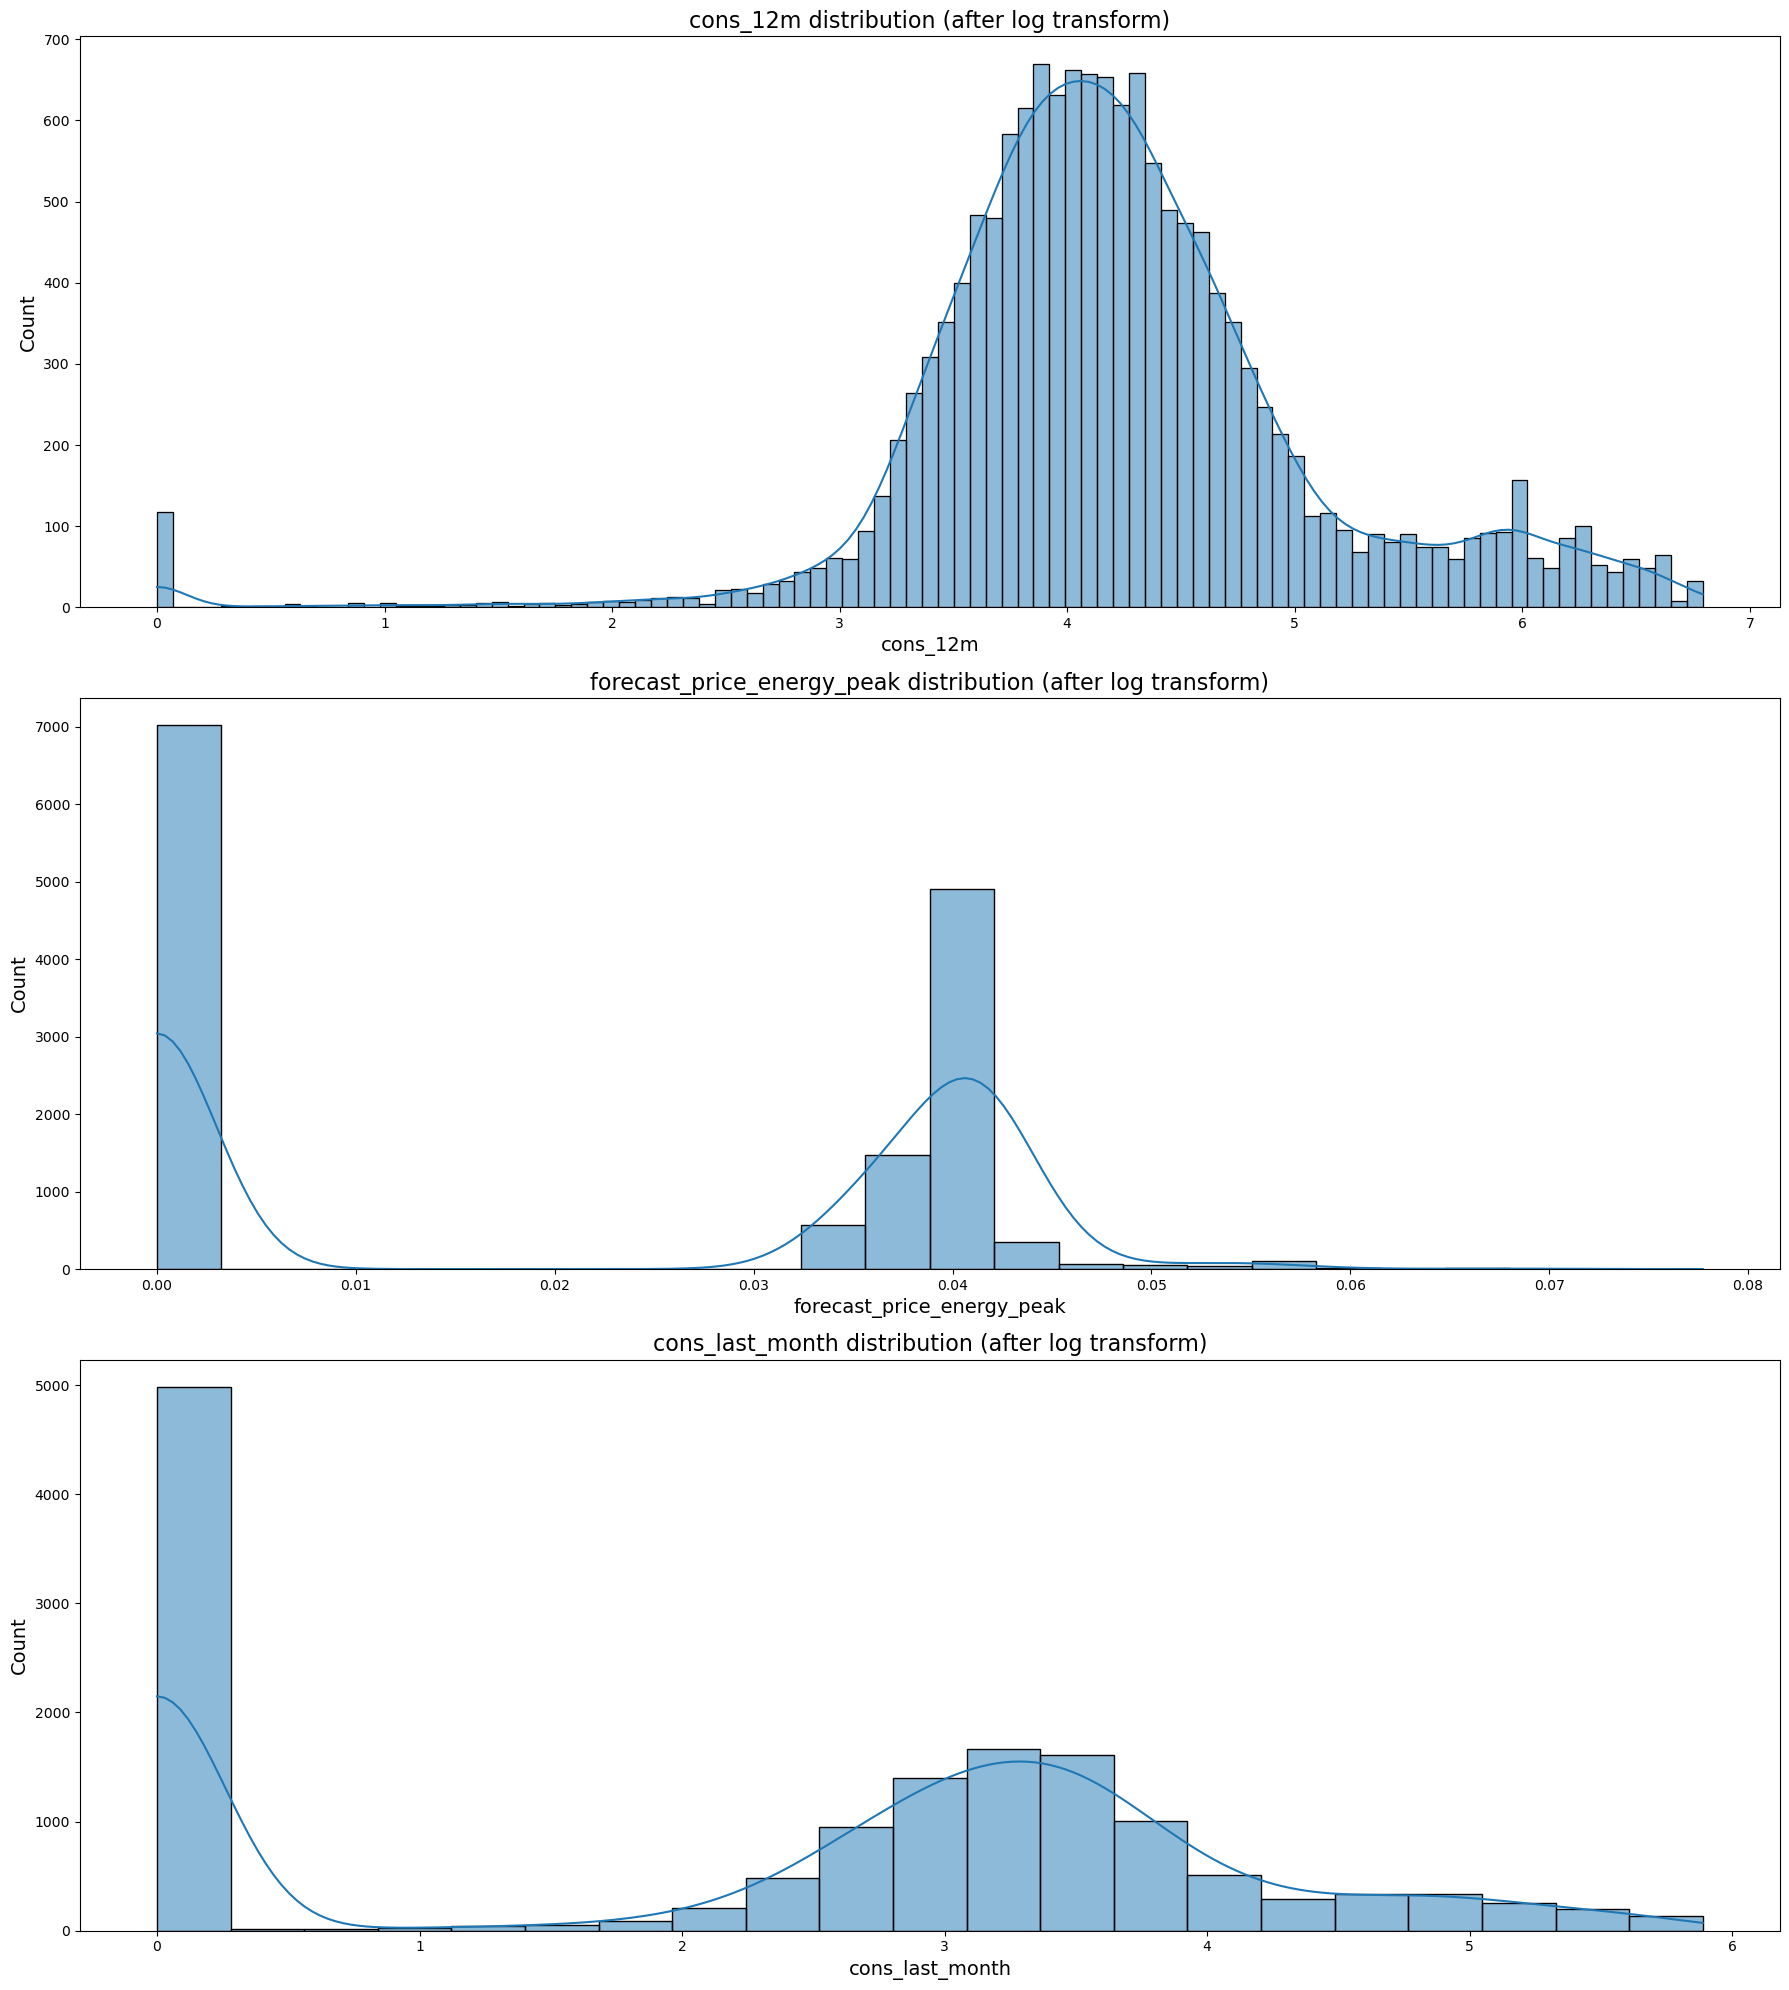

In [20]:
# Visualize the transformation effect on a few key columns
cols_to_plot = ["cons_12m", "forecast_price_energy_peak", "cons_last_month"]

fig, axs = plt.subplots(nrows=len(cols_to_plot), figsize=(18, 20))

for ax, col in zip(axs, cols_to_plot):
    sns.histplot(df[col].dropna(), kde=True, ax=ax)
    ax.set_title(f"{col} distribution (after log transform)", fontsize=16)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)

plt.tight_layout()
plt.show()

**Visual Confirmation**: The transformed distributions are much closer to normal, which will improve model performance.

---

### Phase 11: Correlation Analysis and Feature Selection

**Business Intuition**: Highly correlated features contain redundant information. Removing them improves model interpretability and reduces overfitting.

**Why this matters**: Correlated features can confuse models and make coefficients unreliable. We want independent features that each add unique predictive value.

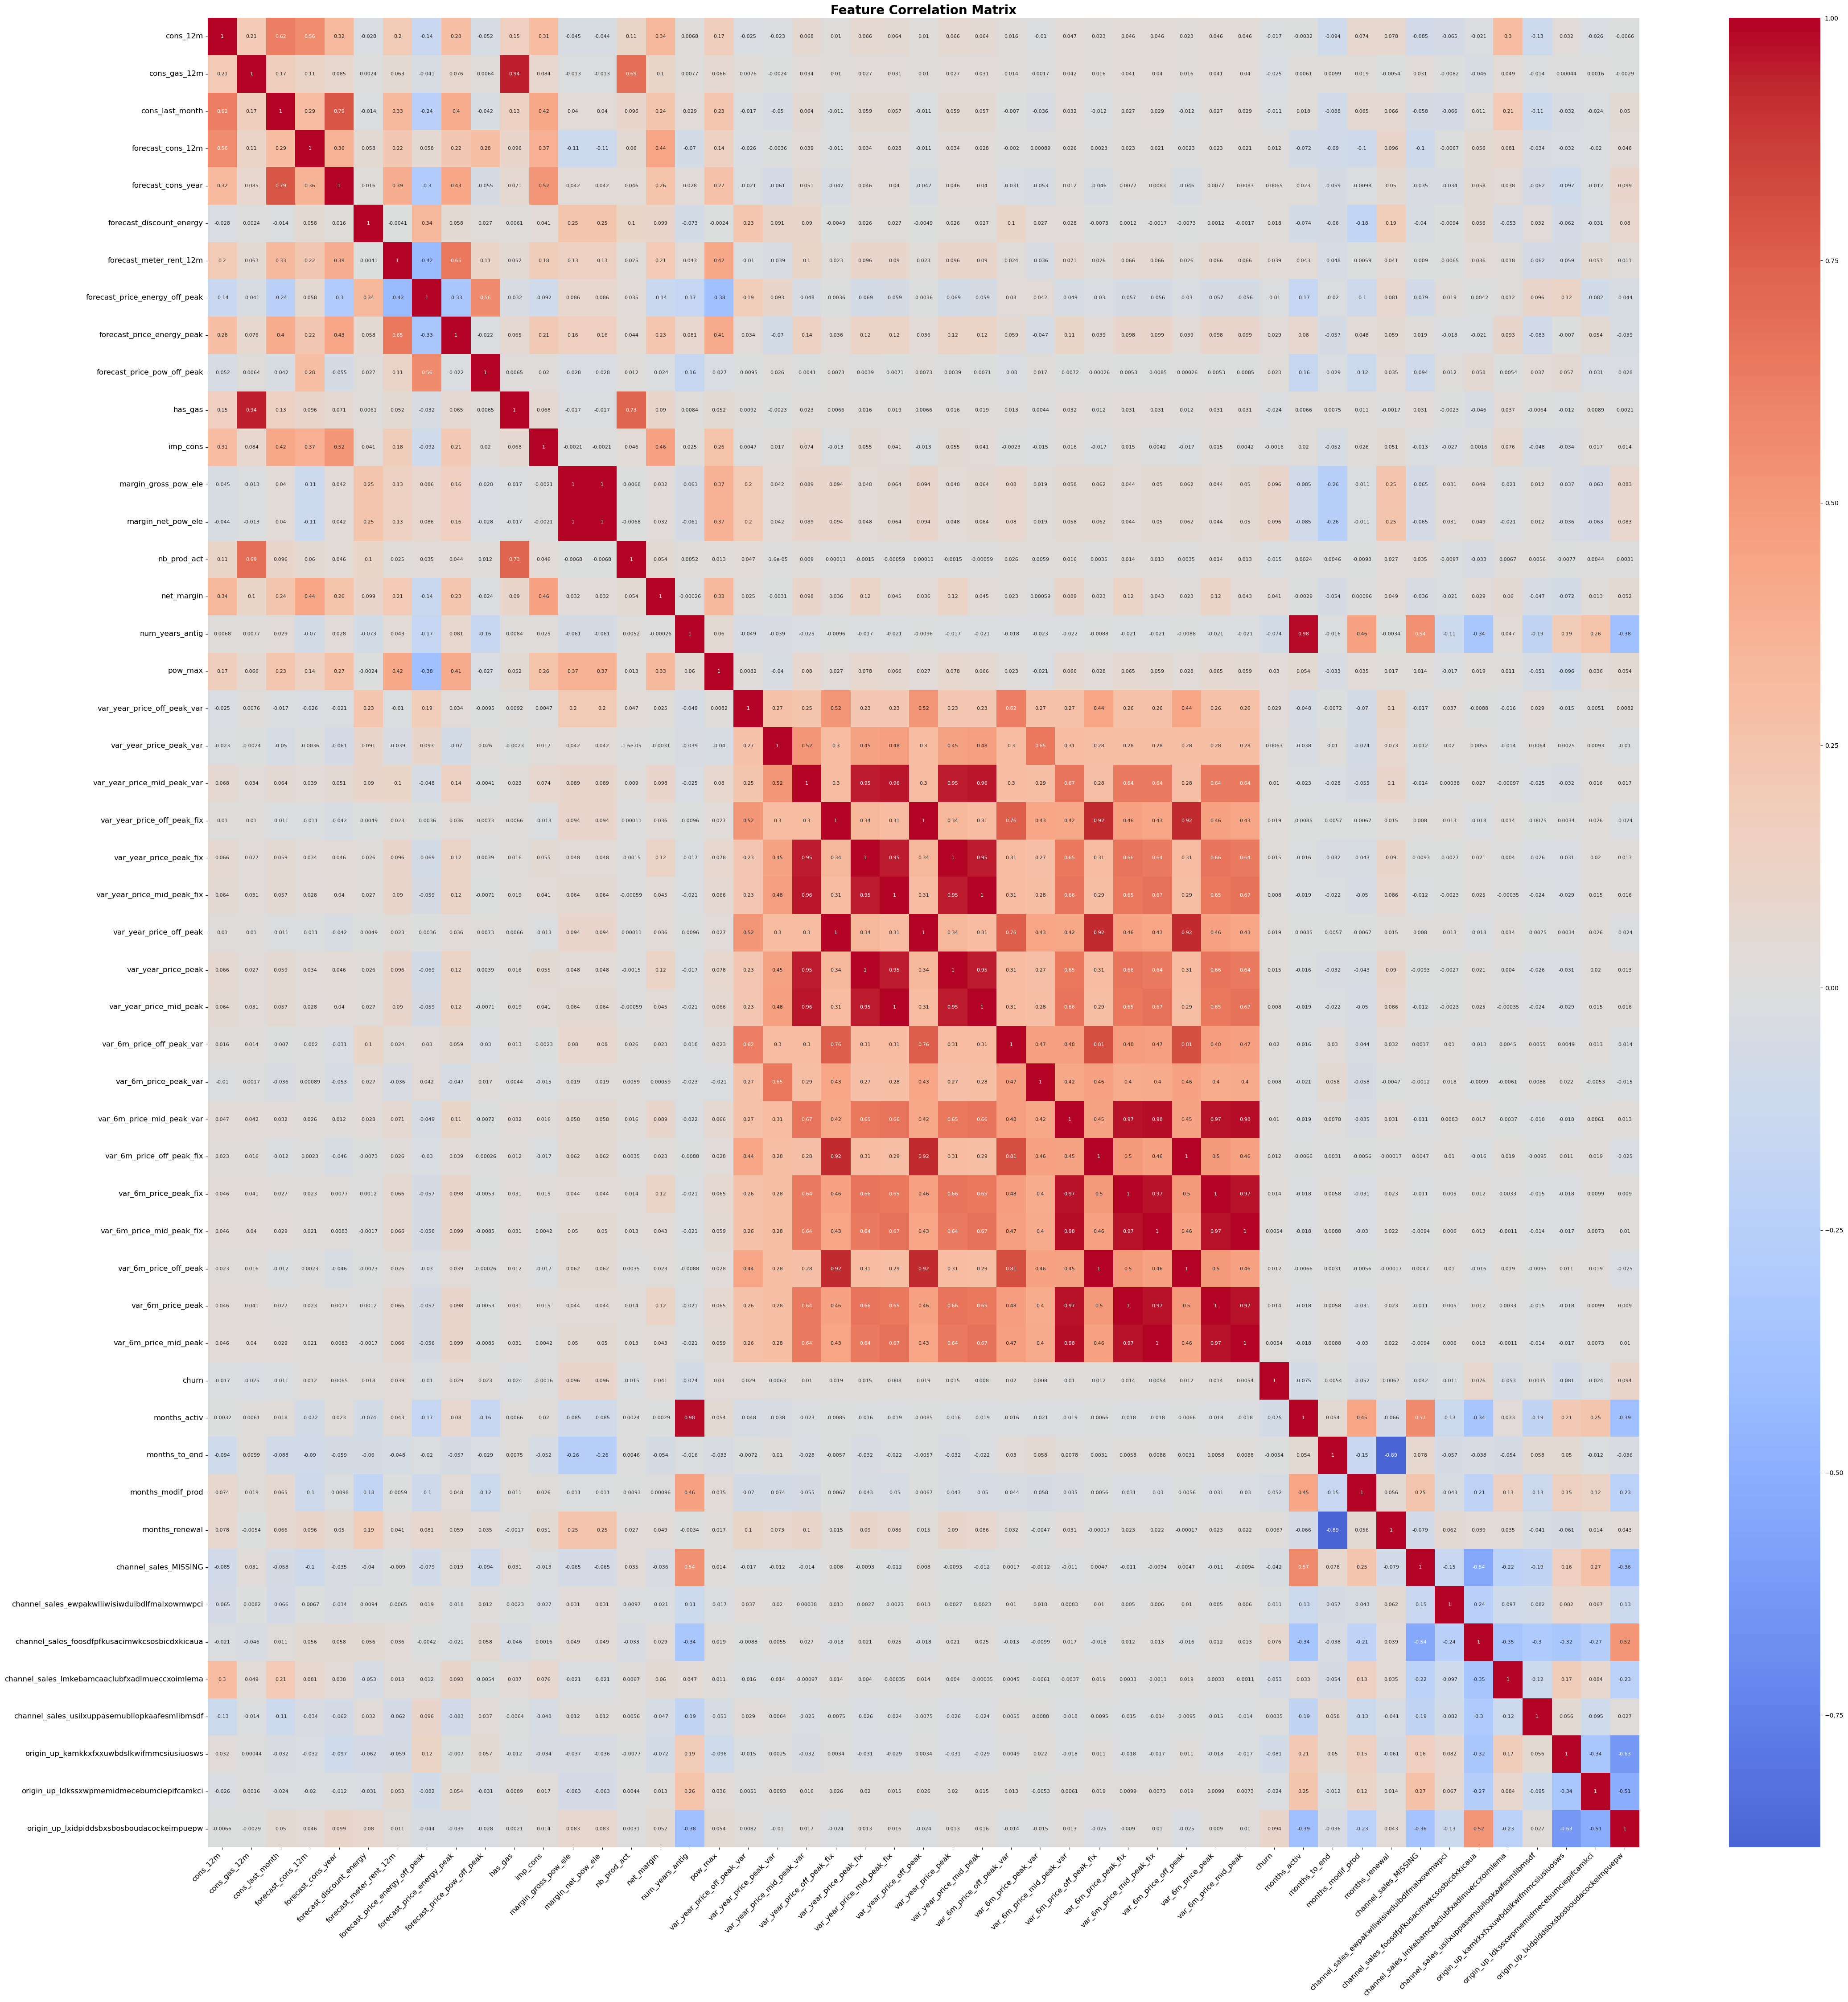

In [21]:
# Calculate correlations (excluding ID column)
correlation = df.drop(columns=['id']).corr()

# Create large correlation heatmap
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 8},
    cmap='coolwarm',
    center=0
)

plt.title('Feature Correlation Matrix', fontsize=20, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [22]:
# Identify highly correlated pairs (|correlation| > 0.95)
high_corr_threshold = 0.95
high_corr_pairs = []

for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        corr_val = abs(correlation.iloc[i, j])
        if corr_val > high_corr_threshold:
            col1 = correlation.columns[i]
            col2 = correlation.columns[j]
            high_corr_pairs.append((col1, col2, correlation.iloc[i, j]))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated pairs (|correlation| > {high_corr_threshold}):")
    for col1, col2, corr in high_corr_pairs:
        print(".3f")
        
    print("\nRecommendation: Consider removing one feature from each highly correlated pair")
    print("Common candidates for removal: num_years_antig, forecast_cons_year")
else:
    print("No highly correlated feature pairs found")

Found 22 highly correlated pairs (|correlation| > 0.95):
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f
.3f

Recommendation: Consider removing one feature from each highly correlated pair
Common candidates for removal: num_years_antig, forecast_cons_year


In [23]:
# Remove highly correlated features (following model answer)
cols_to_remove = ['num_years_antig', 'forecast_cons_year']  # These are redundant with tenure features we created

existing_cols_to_remove = [col for col in cols_to_remove if col in df.columns]
if existing_cols_to_remove:
    df = df.drop(columns=existing_cols_to_remove)
    print(f"Removed {len(existing_cols_to_remove)} highly correlated features: {existing_cols_to_remove}")

Removed 2 highly correlated features: ['num_years_antig', 'forecast_cons_year']


---

## Final Dataset Summary and Export

**Business Intuition**: A clean, well-engineered dataset is the foundation of successful predictive modeling.

In [24]:
# Final dataset assessment
print("FEATURE ENGINEERING COMPLETE!")
print(f"Original columns: 44")
print(f"Final columns: {df.shape[1]}")
print(f"New features engineered: {df.shape[1] - 44}")

print(f"\nDataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")

# Data type summary
print(f"\nData types:")
print(df.dtypes.value_counts())

# Final missing values check
missing_vals = df.isnull().sum().sum()
if missing_vals == 0:
    print("No missing values")
else:
    print(f"{missing_vals} missing values remain")

# Top features correlated with churn
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
if 'churn' in numeric_cols:
    churn_corr = df[numeric_cols].corr()['churn'].abs().sort_values(ascending=False)
    print(f"\nTop 10 features correlated with churn:")
    for feature, corr in churn_corr.head(11).items():
        if feature != 'churn':
            print(".4f")

# Export final dataset
final_filename = 'final_engineered_features.csv'
df.to_csv(final_filename, index=False)
print(f"\nFinal dataset saved as: {final_filename}")
print("Ready for churn prediction modeling!")

FEATURE ENGINEERING COMPLETE!
Original columns: 44
Final columns: 48
New features engineered: 4

Dataset dimensions: 14606 rows × 48 columns

Data types:
float64    32
int64      15
object      1
Name: count, dtype: int64
No missing values

Top 10 features correlated with churn:
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f
.4f

Final dataset saved as: final_engineered_features.csv
Ready for churn prediction modeling!
